In [2]:
import numpy as np
import pandas as pd

from typing import List, Tuple
import matplotlib.pyplot as plt
import math

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


# Fix the random seed for reproducibility
# !! Important !! : do not change this
# hw1_seed = 1234
# np.random.seed(hw1_seed)  
# pd.options.mode.chained_assignment = None 

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = pd.read_csv(r"C:\Users\Varshini\Downloads\diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv")
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.drop(columns=["readmitted"])  
y = diabetes_130_us_hospitals_for_years_1999_2008["readmitted"]
#X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
#y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 
  
# metadata 
#print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
#print(diabetes_130_us_hospitals_for_years_1999_2008.variables) 

## testing splits ##

## 20 percent set aside
X_temp, X_te, y_temp, y_te = train_test_split(X, y, 
                                    test_size=0.20, random_state=1234, shuffle=True)

## that 75/25 split for the end 
X_tr, X_val, y_tr, y_val = train_test_split(X_temp, y_temp, 
                                    test_size=0.25, random_state=1234, shuffle=True)


In [47]:
#rebecca 
#print(X_tr.dtypes)

def split_by_type(X):
    X_num = X.select_dtypes(include=['int64'])
    X_object = X.select_dtypes(include=['object'])
    return X_num, X_object

X_num, X_object = split_by_type(X_tr)
y_num, y_object = split_by_type(y_tr)
#print(X_num)
#print(X_object)

def summary_num(X):
    summary_table = []
    def get_mean(subset, col):
        return np.nanmean(subset[col], axis=0)
    def get_std(subset, col):
        return np.nanstd(subset[col], axis=0)
    def get_median(subset, col):
        return np.nanmedian(subset[col], axis=0)
    def get_var(subset, col):
        return np.nanvar(subset[col], axis=0)
    total_features = X.columns
    for col in total_features:
        summary_table.append([get_mean(X, col), get_std(X, col), get_median(X, col), get_var(X, col)])
    summary_table = np.to_array(summary_table)
    return summary_table

#print(summary_num(X_num))
    
    


0.43544768175043813
0.4336952783373459


[Text(0.5, 0.8333333333333334, 'x[11] <= -0.11\ngini = 0.575\nsamples = 61059\nvalue = [6832, 21379, 32848]'),
 Text(0.25, 0.5, 'x[1] <= -0.616\ngini = 0.525\nsamples = 40455\nvalue = [3427, 12189, 24839]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.464\nsamples = 14844\nvalue = [1162, 3442, 10240]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.551\nsamples = 25611\nvalue = [2265, 8747, 14599]'),
 Text(0.75, 0.5, 'x[11] <= 0.675\ngini = 0.623\nsamples = 20604\nvalue = [3405, 9190, 8009]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.603\nsamples = 11796\nvalue = [1518, 4918, 5360]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.628\nsamples = 8808\nvalue = [1887.0, 4272.0, 2649.0]')]

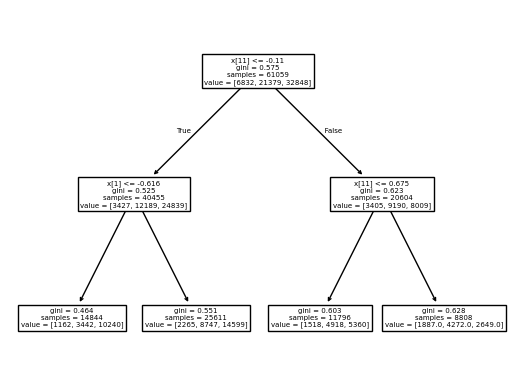

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#3 order ; one hot encoding <- splits categorical into more features 1/0 if yes/no and Standard scaler for scaling data


# replacing ? with NAN and replacing NAN with the mode
X = X.replace("?", np.nan)
y = y.replace("?", np.nan)

for col in X.columns:
    X[col] = X[col].fillna(X[col].mode()[0])


categorical = X_tr.select_dtypes(include=['object']).columns.tolist()
numerical = X_tr.select_dtypes(include=['int64']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

##### COL TRANSFORMER NUM AND CAT COLUMNS <- joins them tgt and applies scaler and encoder
preproc = ColumnTransformer(transformers = [('num', scaler, numerical), ('cat', encoder, categorical)])
X_tr_2 = preproc.fit_transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)

hw1_seed = 1234
clf = DecisionTreeClassifier(max_depth=2, random_state=hw1_seed)
clf.fit(X_tr_2, y_tr)

clf_err_tr = 1-clf.score(X_tr_2, y_tr)
clf_err_val = 1-clf.score(X_val_2, y_val)

print(clf_err_tr)
print(clf_err_val)

plot_tree(clf)

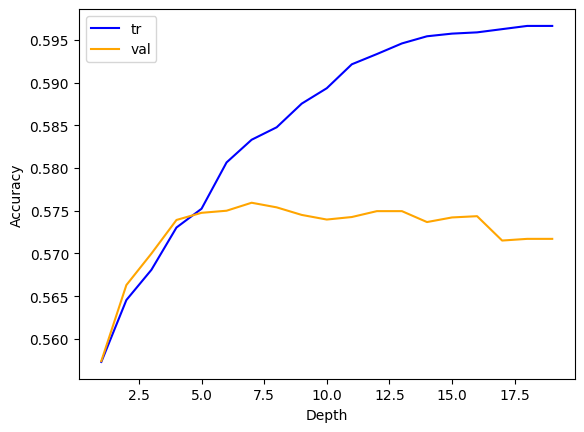

In [67]:
# decision tree w/ different max_depths
training_curve = []
testing_curve = []
max_depths = np.arange(1,20,1)
for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=hw1_seed, min_samples_leaf = 95)
    clf.fit(X_tr_2, y_tr)

    clf_acc_tr = clf.score(X_tr_2, y_tr)
    clf_acc_val = clf.score(X_val_2, y_val)
    training_curve.append(clf_acc_tr)
    testing_curve.append(clf_acc_val)
    
plt.plot(max_depths, training_curve, label='tr', color = 'blue')
plt.plot(max_depths, testing_curve, label='val', color = 'orange')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()

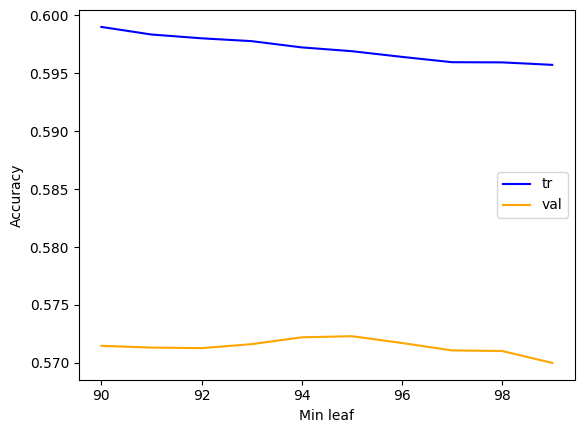

In [63]:
training_curve = []
testing_curve = []
min_leaf_samples = np.arange(90,100,1)
for min_leaf in min_leaf_samples:
    clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=min_leaf, random_state=hw1_seed)
    clf.fit(X_tr_2, y_tr)

    clf_acc_tr = clf.score(X_tr_2, y_tr)
    clf_acc_val = clf.score(X_val_2, y_val)
    training_curve.append(clf_acc_tr)
    testing_curve.append(clf_acc_val)
    
plt.plot(min_leaf_samples, training_curve, label='tr', color = 'blue')
plt.plot(min_leaf_samples, testing_curve, label='val', color = 'orange')
plt.xlabel('Min leaf')
plt.ylabel('Accuracy')
plt.legend()

1


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


10


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


25


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


50


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


75


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


100


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


200


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


350


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


500


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


1000


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


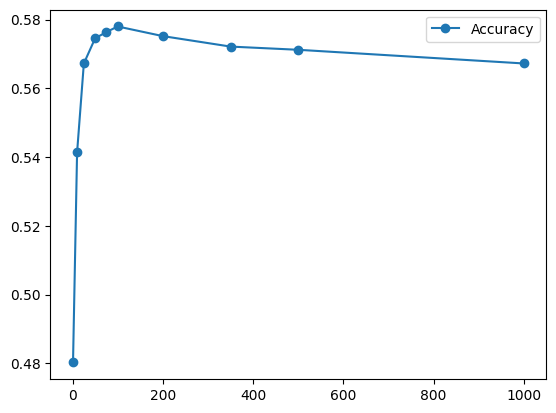

BEST K FOUND: 100 0.578


In [ ]:
#amy
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
#3 order ; one hot encoding <- splits categorical into more features 1/0 if yes/no and Standard scaler for scaling data


# replacing ? with NAN and replacing NAN with the mode
X = X.replace("?", np.nan)
y = y.replace("?", np.nan)

for col in X.columns:
    X[col] = X[col].fillna(X[col].mode()[0])


categorical = X_tr.select_dtypes(include=['object']).columns.tolist()
numerical = X_tr.select_dtypes(include=['int64']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

##### COL TRANSFORMER NUM AND CAT COLUMNS <- joins them tgt and applies scaler and encoder
preproc = ColumnTransformer(transformers = [('num', scaler, numerical), ('cat', encoder, categorical)])
X_tr_2 = preproc.fit_transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)

svd = TruncatedSVD(n_components=47, random_state=1234)
X_tr_svd = svd.fit_transform(X_tr_2)
X_val_svd = svd.transform(X_val_2)
X_te_svd = svd.transform(X_te_2)

accs = []

best_k = None
best_acc = 0
# errs = []
k_vals = [1, 10, 25,50,75, 100, 200, 350, 500, 1000] ## 1-50 = 7.5 mins, 1-1000+ = 11.5 mins
for i, k in enumerate(k_vals):
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k)

    # knn.fit(X_tr_2, y_tr)
    # pred = knn.predict(X_val_2)

    ### SVD IMPLEMENTATION

    knn.fit(X_tr_svd, y_tr)
    pred = knn.predict(X_val_svd)
    acc = accuracy_score(y_val, pred)

    ####

    accs.append(acc)

    if acc > best_acc:
        best_acc = acc
        best_k = k
    # errs.append(1-acc)
## TODO: some of that ravel error stuff ? doesnt matter long run tho
plt.plot(k_vals, accs, marker='o', label='Accuracy')
plt.legend()
plt.show()
print("BEST K FOUND:", best_k, round(best_acc, 4))

c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Test Accuracy with best k (100): 0.5744

Classification Report:
               precision    recall  f1-score   support

         <30       0.46      0.01      0.02      2308
         >30       0.52      0.24      0.33      7106
          NO       0.59      0.91      0.71     10940

    accuracy                           0.57     20354
   macro avg       0.52      0.39      0.35     20354
weighted avg       0.55      0.57      0.50     20354



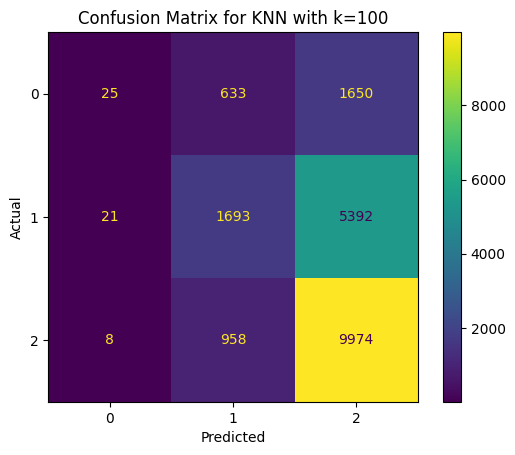

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_confusion_matrix(y, y_pred):
    
    ### YOUR CODE STARTS HERE ###
    tp_labels = []
    conf_matrix = []
    for i in range(len(y)):
        tp_labels.append([y[i], y_pred[i]])
    #     conf_matrix.append([0 for j in range(len(y))])
    # print(conf_matrix)
    conf_matrix = np.zeros((10, 10), dtype=int)
    for y1, y2 in tp_labels:
        # print(y1, y2)
        # print(conf_matrix[y1][y2])
        conf_matrix[y1][y2] += 1
        
    ### YOUR CODE ENDS HERE ###
    return np.array(conf_matrix)

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_tr_svd, y_tr)
y_pred_test = best_knn.predict(X_te_svd)

acc = accuracy_score(y_te, y_pred_test)
print("Test Accuracy with best k ({}): {:.4f}".format(best_k, acc))

conf_matrix = confusion_matrix(y_te, y_pred_test)
report = classification_report(y_te, y_pred_test)

print("\nClassification Report:\n", report)

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)

disp.plot()
plt.title(f'Confusion Matrix for KNN with k={best_k}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [8]:
#varsh
#logistic regression
seed = 1234
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#3 order ; one hot encoding <- splits categorical into more features 1/0 if yes/no and Standard scaler for scaling data



def logistic_regression(X, y, hyperparams): 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    #  set the state of the random number generator so that we get the same results across runs when testing our code

    ### YOUR CODE START HERE ### 

    # Specify the logistic classifier model
    # # Please use 'l1' penality type, 'liblinear' solver and enable fit_intercept
    classifier = LogisticRegression(**hyperparams)
    # Train a logistic regression classifier and evaluate accuracy on the training data
    print('\nTraining a model with', X_train.shape[0], 'examples.....')
    # Training 
    classifier.fit(X_train, y_train)
    
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print('\nTraining accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)

    ### YOUR CODE ENDS HERE ###
    print('\nTesting accuracy:', format( 100*test_accuracy , '.2f') )

    return classifier, train_accuracy, test_accuracy

param_grid = [
    {'penalty': 'l1', 'solver': 'liblinear', 'fit_intercept': True, 'C': 1.0},
    {'penalty': 'l2', 'solver': 'lbfgs', 'fit_intercept': True, 'C': 1.0},
    {'penalty': 'l1', 'solver': 'liblinear', 'fit_intercept': False, 'C': 0.1},
    {'penalty': 'l2', 'solver': 'lbfgs', 'fit_intercept': True, 'C': 0.01},
] 
results = []

for param in param_grid:
    _, train_acc, test_acc = logistic_regression(X_tr_2, y_tr, param)
    results.append((param, train_acc, test_acc))


Training a model with 42741 examples.....

Training accuracy: 60.34

Testing accuracy: 57.98

Training a model with 42741 examples.....


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training accuracy: 60.31

Testing accuracy: 58.03

Training a model with 42741 examples.....

Training accuracy: 58.83

Testing accuracy: 57.97

Training a model with 42741 examples.....

Training accuracy: 59.39

Testing accuracy: 58.30


In [ ]:
df = pd.DataFrame(results, columns=['hyperparams', 'train_acc', 'test_acc'])
df['param_str'] = df['hyperparams'].apply(lambda d: ', '.join(f"{k}={v}" for k,v in d.items()))

print(df[['param_str', 'train_acc', 'test_acc']].to_string(index=False))

                                               param_str  train_acc  test_acc
 penalty=l1, solver=liblinear, fit_intercept=True, C=1.0   0.603495  0.579758
     penalty=l2, solver=lbfgs, fit_intercept=True, C=1.0   0.603098  0.580304
penalty=l1, solver=liblinear, fit_intercept=False, C=0.1   0.588358  0.579648
    penalty=l2, solver=lbfgs, fit_intercept=True, C=0.01   0.593926  0.582978


In [14]:

#feedforward neural network

hyperparameter_grid = [
    {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1, 'learning_rate_init': 0.05},
    {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate_init': 0.01},
    {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate_init': 0.01},
    {'hidden_layer_sizes': (100, 100), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (64,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.01}
]


def train_mlp_with_hyperparameters(hyper_params, X_tr_10k, y_tr_10k, X_val_10k, y_val_10k, X_te_scaled, y_te, seed) -> Tuple[float, float, float]:
    mlp = MLPClassifier(**hyper_params, shuffle=True, random_state=seed, verbose=False)
    mlp.fit(X_tr_10k, y_tr_10k)
    train_accuracy = mlp.score(X_tr_10k, y_tr_10k)
    val_accuracy = mlp.score(X_val_10k, y_val_10k)
    test_accuracy = mlp.score(X_te_scaled, y_te)
    
    print('Hyperparameters performance:')
    print(f'Training accuracy: {train_accuracy}')
    print(f'Validation accuracy: {val_accuracy}')
    print(f'Test accuracy: {test_accuracy}')
    return train_accuracy, val_accuracy, test_accuracy

# #best_hyperparams = {'hidden_layer_sizes': (100,),
#                     'activation': 'relu', 
#                     'solver': 'sgd',
#                     'alpha': .1,
#                     'learning_rate': 'constant',
#                     'learning_rate_init': .05,
#                     'max_iter': 100,
#                     'n_iter_no_change': 1}

results = []

for i, params in enumerate(hyperparameter_grid):
    print(f"\n--- Trying config {i+1} ---")
    
    # Fill in the missing required fields for consistency
    full_params = params.copy()
    full_params.update({
        'learning_rate': 'constant',
        'max_iter': 100,
        'n_iter_no_change': 1
    })
    
    # Train and get accuracies
    accs = train_mlp_with_hyperparameters(full_params, X_tr_2, y_tr, X_val_2, y_val, X_te_2, y_te, seed)
    
    # Store results: (params_dict, train_acc, val_acc, test_acc)
    results.append((params, *accs))


#train_mlp_with_hyperparameters(best_hyperparams, X_tr_2, y_tr, X_val_2, y_val, X_te_2, y_te, seed)



--- Trying config 1 ---
Hyperparameters performance:
Training accuracy: 0.628113791578637
Validation accuracy: 0.5958826708593328
Test accuracy: 0.5942320919720939

--- Trying config 2 ---


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameters performance:
Training accuracy: 0.6446551695900686
Validation accuracy: 0.5645850734535449
Test accuracy: 0.557433428318758

--- Trying config 3 ---


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameters performance:
Training accuracy: 0.6438690446944758
Validation accuracy: 0.5916572495455216
Test accuracy: 0.590056008646949

--- Trying config 4 ---
Hyperparameters performance:
Training accuracy: 0.9650665749520955
Validation accuracy: 0.5019898786419692
Test accuracy: 0.49808391470963936

--- Trying config 5 ---
Hyperparameters performance:
Training accuracy: 0.888615928855697
Validation accuracy: 0.5050852454183659
Test accuracy: 0.49896826176672887


In [22]:
# df = pd.DataFrame(results)
# # Make accuracies in percentage format for readability
# df['train_acc'] = df['train_acc'] * 100
# df['val_acc'] = df['val_acc'] * 100
# df['test_acc'] = df['test_acc'] * 100

# print(df[['config', 'params', 'train_acc', 'val_acc', 'test_acc']])

pd.set_option('display.max_colwidth', None)  # disables truncation/wrapping on wide cells
pd.set_option('display.width', 200)  

df = pd.DataFrame([
    {
        **res[0],  # unpack hyperparameter dict
        'train_acc': res[1]*100,  # convert to percentage
        'val_acc': res[2]*100,
        'test_acc': res[3]*100,
    }
    for res in results
])
print(df)

  hidden_layer_sizes activation solver   alpha  learning_rate_init  train_acc    val_acc   test_acc
0             (100,)       relu    sgd  0.1000               0.050  62.811379  59.588267  59.423209
1             (100,)       relu    sgd  0.0100               0.010  64.465517  56.458507  55.743343
2              (50,)       tanh    sgd  0.0010               0.010  64.386904  59.165725  59.005601
3         (100, 100)       relu   adam  0.0001               0.001  96.506657  50.198988  49.808391
4              (64,)   logistic   adam  0.0001               0.010  88.861593  50.508525  49.896826


In [ ]:
# #varsh
# #error for training sizes in mlp and regression 
# seed = 1234
# def errors_for_train_sizes_mlp(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, train_sizes: list[int]) -> tuple[list, list, list, list]:
#     # append error rates to the following lists
#     tr_err_mlp = [] # training error rates for MLP
#     te_err_mlp = [] # testing error rates for MLP

#     ### YOUR CODE STARTS HERE ###
#     for n_tr in train_sizes:
#         clf = MLPClassifier(hidden_layer_sizes=(64,), random_state=seed, activation='relu', solver='sgd', batch_size=256, learning_rate_init=0.001)
#         clf.fit(X_tr[:n_tr], y_tr[:n_tr])
#         tr_err_mlp.append(1 - clf.score(X_tr[:n_tr], y_tr[:n_tr]))
#         te_err_mlp.append(1 - clf.score(X_te, y_te))
#     ###  YOUR CODE ENDS HERE  ###
#     return tr_err_mlp, te_err_mlp # DO NOT CHANGE THIS LINE

# def errors_for_train_sizes_lr(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, train_sizes: list[int]) -> tuple[list, list, list, list]:    
#     # append error rates to the following lists
#     tr_err_lr = [] # training error rates for Logistic Regression
#     te_err_lr = [] # testing error rates for Logistic Regression

#     ### YOUR CODE STARTS HERE ###
#     for n_tr in train_sizes:
#         clf = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
#         clf.fit(X_tr[:n_tr], y_tr[:n_tr])
#         tr_err_lr.append(1 - clf.score(X_tr[:n_tr], y_tr[:n_tr]))
#         te_err_lr.append(1 - clf.score(X_te, y_te))
#     ###  YOUR CODE ENDS HERE  ###
#     return tr_err_lr, te_err_lr # DO NOT CHANGE THIS LINE


# #decision tree errors for training size 
# def errors_for_train_sizes_dt(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, train_sizes: list[int], min_leaf: int = 1) -> tuple[list, list]:
#     # Append error rates to the following lists
#     tr_err_dt = []  # training error rates for Decision Tree
#     te_err_dt = []  # testing error rates for Decision Tree

#     for n_tr in train_sizes:
#         clf = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=seed)
#         clf.fit(X_tr[:n_tr], y_tr[:n_tr])
#         tr_err_dt.append(1 - clf.score(X_tr[:n_tr], y_tr[:n_tr]))
#         te_err_dt.append(1 - clf.score(X_te, y_te))

#     return tr_err_dt, te_err_dt

# #varsh
# #knn error with training sizes
# def errors_for_train_sizes_knn(X_tr, y_tr, X_te, y_te, train_sizes, k=10):
#     tr_err_knn = []
#     te_err_knn = []

#     for n_tr in train_sizes:
#         clf = KNeighborsClassifier(n_neighbors=k)
#         clf.fit(X_tr[:n_tr], y_tr[:n_tr])
#         train_acc = clf.score(X_tr[:n_tr], y_tr[:n_tr])
#         test_acc = clf.score(X_te, y_te)
#         print(f"[KNN] Train size: {n_tr}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
#         tr_err_knn.append(1 - train_acc)
#         te_err_knn.append(1 - test_acc)

#     return tr_err_knn, te_err_knn

[KNN] Train size: 50, Train Acc: 0.5800, Test Acc: 0.5252
[KNN] Train size: 500, Train Acc: 0.6160, Test Acc: 0.5143
[KNN] Train size: 2000, Train Acc: 0.6175, Test Acc: 0.5348
[KNN] Train size: 5000, Train Acc: 0.6364, Test Acc: 0.5354
[KNN] Train size: 10000, Train Acc: 0.6381, Test Acc: 0.5424
[KNN] Train size: 20000, Train Acc: 0.6423, Test Acc: 0.5443


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Varshini\.anaconda\envs\cs178

NameError: name 'lt' is not defined

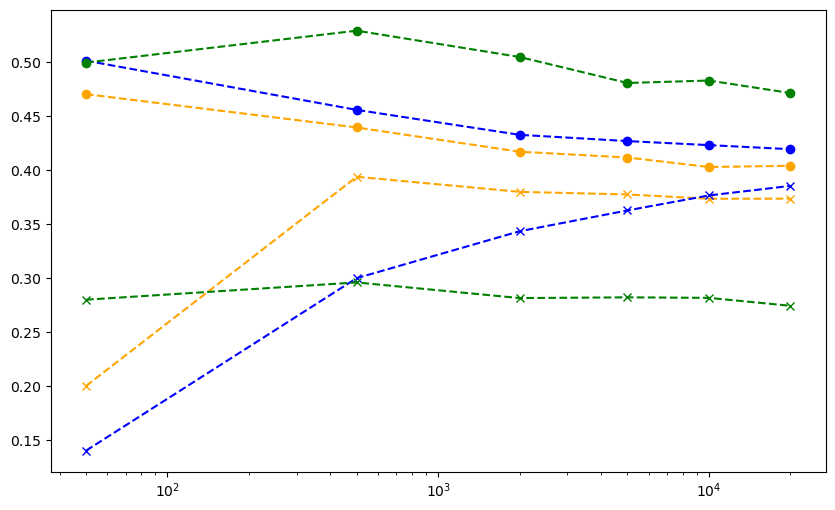

In [ ]:
# #varsh

# train_sizes = [50, 500, 2000, 5000, 10000, 20000]
# tr_err_dt, te_err_dt = errors_for_train_sizes_dt(X_tr_2, y_tr, X_te_2, y_te, seed, train_sizes)
# tr_err_knn, te_err_knn = errors_for_train_sizes_knn(X_tr_2, y_tr, X_te_2, y_te, train_sizes)
# tr_err_mlp, te_err_mlp = errors_for_train_sizes_mlp(X_tr_2, y_tr, X_te_2, y_te, seed, train_sizes)
# tr_err_lr, te_err_lr = errors_for_train_sizes_lr(X_tr_2, y_tr, X_te_2, y_te, seed, train_sizes)

# def plot_errors_for_train_sizes_all(tr_err_mlp: list, te_err_mlp: list,
#                                     tr_err_lr: list, te_err_lr: list,
#                                     tr_err_dt: list, te_err_dt: list,
#                                     tr_err_knn: list, te_err_knn: list,
#                                     train_sizes: list[int]) -> None:
#     plt.figure(figsize=(10, 6))
#     plt.semilogx(train_sizes, tr_err_mlp, 'x--', color='orange', label='Train MLP')
#     plt.semilogx(train_sizes, te_err_mlp, 'o--', color='orange', label='Test MLP')

#     plt.semilogx(train_sizes, tr_err_lr, 'x--', color='blue', label='Train LR')
#     plt.semilogx(train_sizes, te_err_lr, 'o--', color='blue', label='Test LR')

#     plt.semilogx(train_sizes, tr_err_dt, 'x--', color='green', label='Train DT')
#     plt.semilogx(train_sizes, te_err_dt, 'o--', color='green', label='Test DT')

#     lt.semilogx(train_sizes, tr_err_knn, 'x--', color='green', label='Train DT')
#     plt.semilogx(train_sizes, te_err_knn, 'o--', color='green', label='Test DT')

#     plt.xlabel('Num. Training Data Points')
#     plt.ylabel('Error Rate')
#     plt.title('Error Rates vs Training Size')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# train_sizes = [50, 500, 2000, 5000, 10000, 20000]
# tr_err_dt, te_err_dt = errors_for_train_sizes_dt(X_tr_2, y_tr, X_te_2, y_te, seed, train_sizes, min_leaf=10)

# plot_errors_for_train_sizes_all(tr_err_mlp, te_err_mlp, tr_err_lr, te_err_lr, tr_err_dt, te_err_dt, tr_err_knn, te_err_knn, train_sizes)


In [11]:
#regularization errors
def errors_for_regularizations_mlp(X_tr, y_tr, X_te, y_te, seed, alphas, n_tr):
    tr_err_mlp = []
    te_err_mlp = []

    for alpha in alphas:
        clf = MLPClassifier(hidden_layer_sizes=(64,), random_state=seed, activation='relu',
                            solver='sgd', batch_size=256, learning_rate_init=0.001, alpha=alpha)
        clf.fit(X_tr[:n_tr], y_tr[:n_tr])
        train_acc = clf.score(X_tr[:n_tr], y_tr[:n_tr])
        test_acc = clf.score(X_te, y_te)
        print(f"[MLP] Alpha: {alpha}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        tr_err_mlp.append(1 - train_acc)
        te_err_mlp.append(1 - test_acc)

    return tr_err_mlp, te_err_mlp

def errors_for_regularizations_lr(X_tr, y_tr, X_te, y_te, seed, C_values, n_tr):
    tr_err_lr = []
    te_err_lr = []

    for C in C_values:
        clf = LogisticRegression(random_state=seed, C=C, max_iter=1000)
        clf.fit(X_tr[:n_tr], y_tr[:n_tr])
        train_acc = clf.score(X_tr[:n_tr], y_tr[:n_tr])
        test_acc = clf.score(X_te, y_te)
        print(f"[LR ] C: {C}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        tr_err_lr.append(1 - train_acc)
        te_err_lr.append(1 - test_acc)

    return tr_err_lr, te_err_lr

def errors_for_regularizations_knn(X_tr, y_tr, X_te, y_te, neighbor_values, n_tr):
    tr_err_knn = []
    te_err_knn = []

    for k in neighbor_values:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_tr[:n_tr], y_tr[:n_tr])
        train_acc = clf.score(X_tr[:n_tr], y_tr[:n_tr])
        test_acc = clf.score(X_te, y_te)
        print(f"[KNN] k: {k}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        tr_err_knn.append(1 - train_acc)
        te_err_knn.append(1 - test_acc)

    return tr_err_knn, te_err_knn

def errors_for_regularizations_dt(X_tr, y_tr, X_te, y_te, leaf_values, seed):
    tr_err_dt = []
    te_err_dt = []

    for min_leaf in leaf_values:
        clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=min_leaf, random_state=seed)
        clf.fit(X_tr, y_tr)

        train_acc = clf.score(X_tr, y_tr)
        te_acc = clf.score(X_te, y_te)

        print(f"[DT] min_leaf: {min_leaf}, Train Acc: {train_acc:.4f}, Val Acc: {te_acc:.4f}")
        tr_err_dt.append(1 - train_acc)
        te_err_dt.append(1 - te_acc)

    return tr_err_dt, te_err_dt


alphas = [0.0001, 0.001, 0.01, 0.1, 1]
C_values = [100, 10, 1, 0.1, 0.01]  # smaller C → stronger regularization
n_tr = 10000
neighbor_values = [1, 3, 5, 10, 25]
min_leaf_samples = np.arange(90, 100, 1)

tr_err_dt, val_err_dt = errors_for_regularizations_dt(X_tr_2, y_tr, X_val_2, y_val, min_leaf_samples, hw1_seed)
tr_err_mlp, te_err_mlp = errors_for_regularizations_mlp(X_tr_2, y_tr, X_te_2, y_te, seed, alphas, n_tr)
tr_err_lr, te_err_lr = errors_for_regularizations_lr(X_tr_2, y_tr, X_te_2, y_te, seed, C_values, n_tr)
tr_err_knn, te_err_knn = errors_for_regularizations_knn(X_tr_2, y_tr, X_te_2, y_te, neighbor_values, n_tr)

[DT] min_leaf: 90, Train Acc: 0.6184, Val Acc: 0.5862
[DT] min_leaf: 91, Train Acc: 0.6181, Val Acc: 0.5858
[DT] min_leaf: 92, Train Acc: 0.6181, Val Acc: 0.5858
[DT] min_leaf: 93, Train Acc: 0.6181, Val Acc: 0.5858
[DT] min_leaf: 94, Train Acc: 0.6176, Val Acc: 0.5859
[DT] min_leaf: 95, Train Acc: 0.6176, Val Acc: 0.5869
[DT] min_leaf: 96, Train Acc: 0.6170, Val Acc: 0.5873
[DT] min_leaf: 97, Train Acc: 0.6168, Val Acc: 0.5872
[DT] min_leaf: 98, Train Acc: 0.6166, Val Acc: 0.5875
[DT] min_leaf: 99, Train Acc: 0.6164, Val Acc: 0.5873


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[MLP] Alpha: 0.0001, Train Acc: 0.6264, Test Acc: 0.5969


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[MLP] Alpha: 0.001, Train Acc: 0.6256, Test Acc: 0.5968


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[MLP] Alpha: 0.01, Train Acc: 0.6261, Test Acc: 0.5968


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[MLP] Alpha: 0.1, Train Acc: 0.6233, Test Acc: 0.5973


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[MLP] Alpha: 1, Train Acc: 0.6130, Test Acc: 0.5961


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LR ] C: 100, Train Acc: 0.6620, Test Acc: 0.5463
[LR ] C: 10, Train Acc: 0.6628, Test Acc: 0.5482
[LR ] C: 1, Train Acc: 0.6479, Test Acc: 0.5661
[LR ] C: 0.1, Train Acc: 0.6173, Test Acc: 0.5856
[LR ] C: 0.01, Train Acc: 0.5919, Test Acc: 0.5899
[KNN] k: 1, Train Acc: 1.0000, Test Acc: 0.4761
[KNN] k: 3, Train Acc: 0.7275, Test Acc: 0.4791
[KNN] k: 5, Train Acc: 0.6751, Test Acc: 0.5106
[KNN] k: 10, Train Acc: 0.6381, Test Acc: 0.5424
[KNN] k: 25, Train Acc: 0.6158, Test Acc: 0.5634


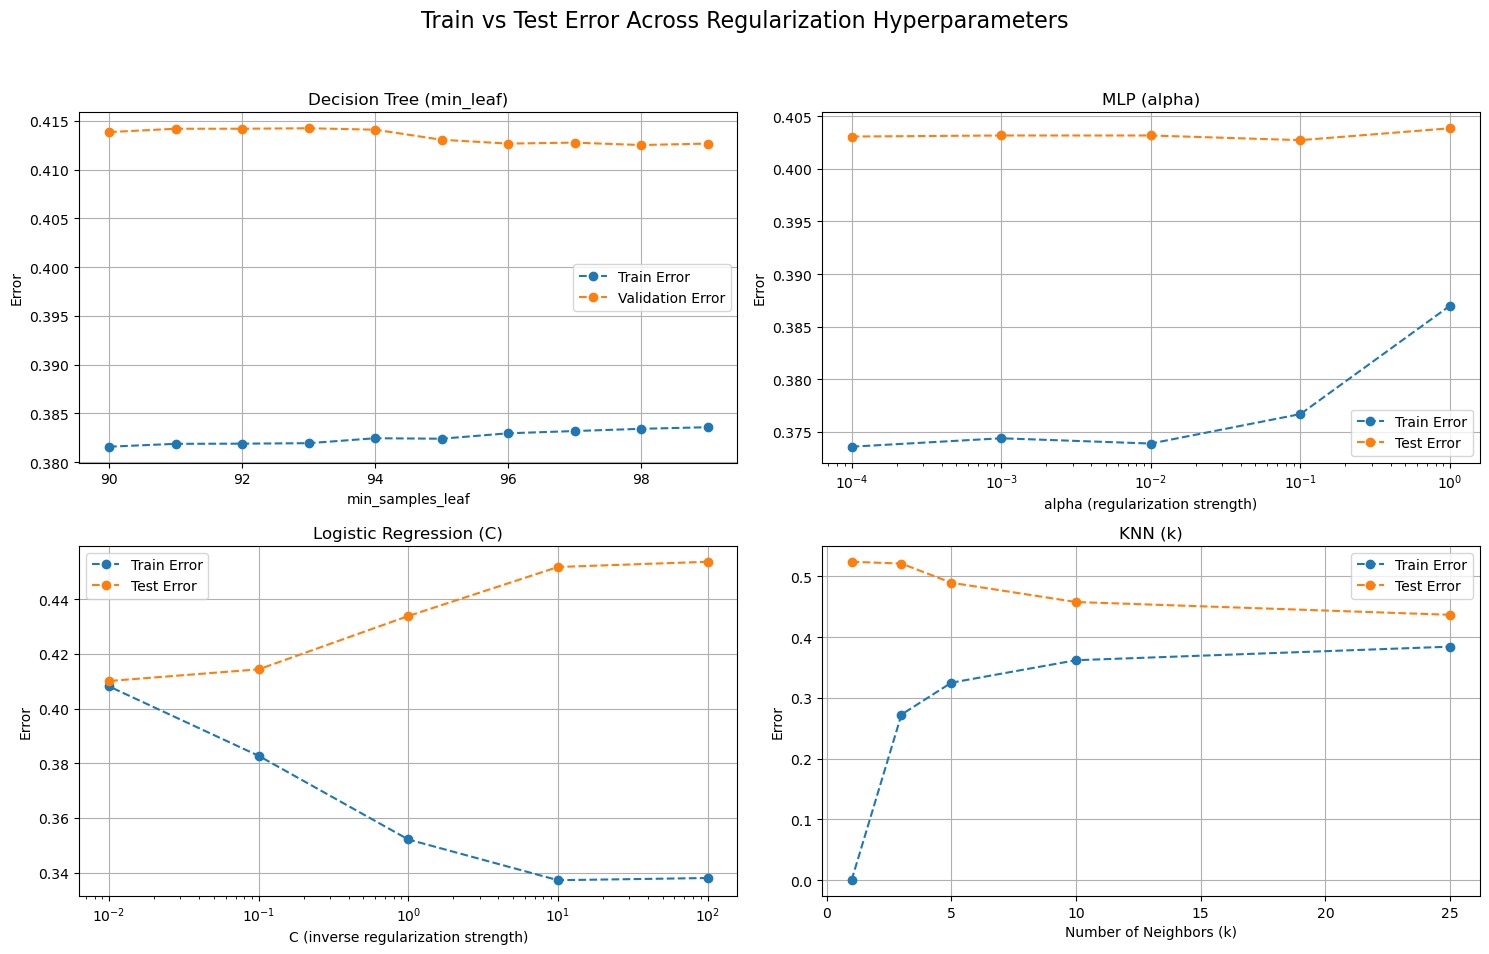

In [12]:
#Plot for regularization

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Train vs Test Error Across Regularization Hyperparameters', fontsize=16)

# --- Decision Tree ---
axs[0, 0].plot(min_leaf_samples, tr_err_dt, 'o--', label='Train Error')
axs[0, 0].plot(min_leaf_samples, val_err_dt, 'o--', label='Validation Error')
axs[0, 0].set_title('Decision Tree (min_leaf)')
axs[0, 0].set_xlabel('min_samples_leaf')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid(True)

# --- MLP ---
axs[0, 1].plot(alphas, tr_err_mlp, 'o--', label='Train Error')
axs[0, 1].plot(alphas, te_err_mlp, 'o--', label='Test Error')
axs[0, 1].set_title('MLP (alpha)')
axs[0, 1].set_xlabel('alpha (regularization strength)')
axs[0, 1].set_xscale('log')
axs[0, 1].set_ylabel('Error')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- Logistic Regression ---
axs[1, 0].plot(C_values, tr_err_lr, 'o--', label='Train Error')
axs[1, 0].plot(C_values, te_err_lr, 'o--', label='Test Error')
axs[1, 0].set_title('Logistic Regression (C)')
axs[1, 0].set_xlabel('C (inverse regularization strength)')
axs[1, 0].set_xscale('log')
axs[1, 0].set_ylabel('Error')
axs[1, 0].legend()
axs[1, 0].grid(True)

# --- KNN ---
axs[1, 1].plot(neighbor_values, tr_err_knn, 'o--', label='Train Error')
axs[1, 1].plot(neighbor_values, te_err_knn, 'o--', label='Test Error')
axs[1, 1].set_title('KNN (k)')
axs[1, 1].set_xlabel('Number of Neighbors (k)')
axs[1, 1].set_ylabel('Error')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Varshin

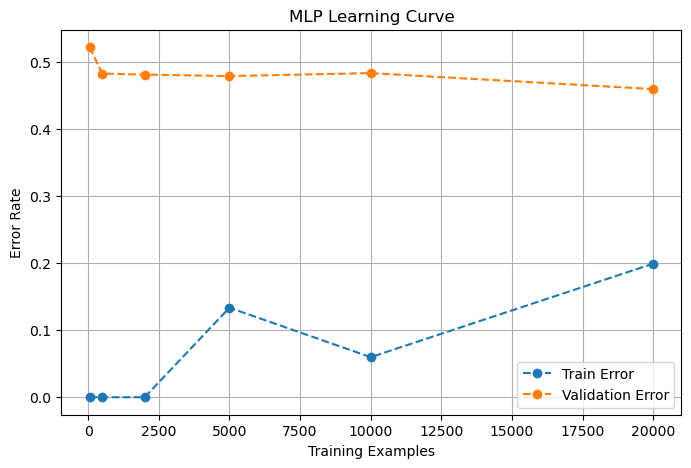

c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

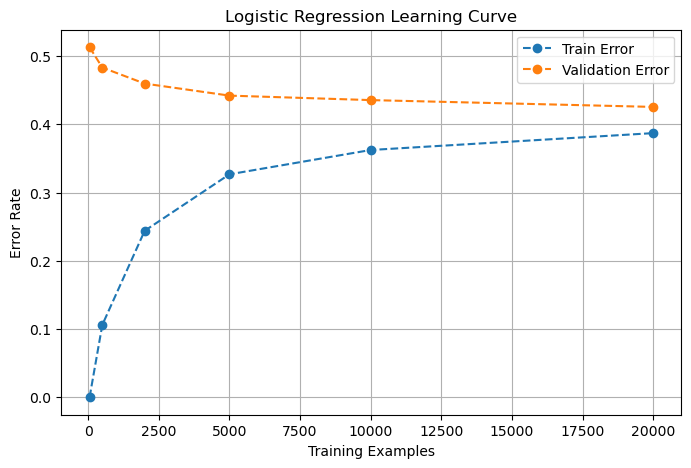

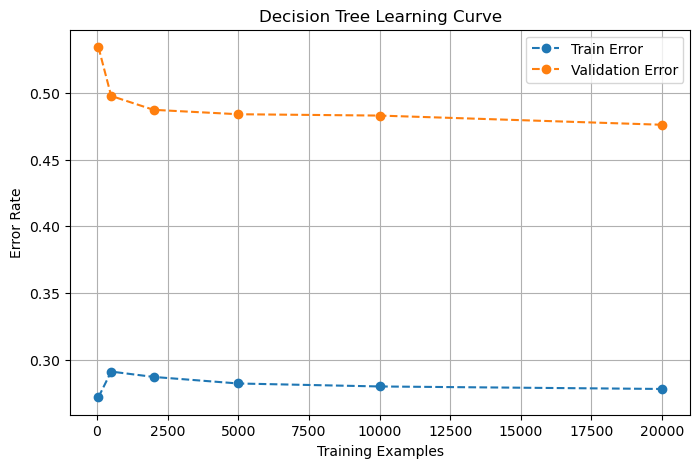

c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "c:\Users\Varshini\.anaconda\envs\cs178\lib\site-

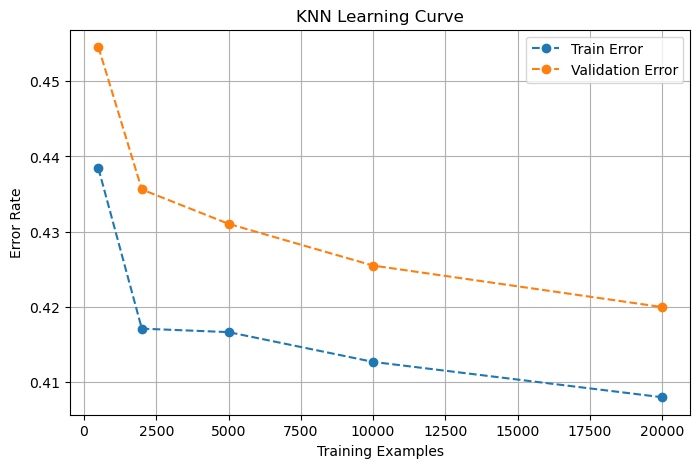

In [14]:
from sklearn.model_selection import learning_curve
seed=1234
def plot_learning_curve(estimator, X, y, title, train_sizes, seed=42):
    train_sizes_abs, train_scores, test_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=5,
        scoring='accuracy',
        shuffle=True,
        random_state=seed
    )

    train_errors = 1 - train_scores.mean(axis=1)
    test_errors = 1 - test_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes_abs, train_errors, 'o--', label='Train Error')
    plt.plot(train_sizes_abs, test_errors, 'o--', label='Validation Error')
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Error Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

train_sizes = [50, 500, 2000, 5000, 10000, 20000]

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), random_state=seed, activation='relu', solver='sgd', alpha=0.1, learning_rate_init=0.05)
plot_learning_curve(mlp, X_tr_2, y_tr, "MLP Learning Curve", train_sizes)

# Logistic Regression
lr = LogisticRegression(penalty='l2', solver='lbfgs', fit_intercept=True)
plot_learning_curve(lr, X_tr_2, y_tr, "Logistic Regression Learning Curve", train_sizes)

# Decision Tree
dt = DecisionTreeClassifier(min_samples_leaf=10, random_state=seed)
plot_learning_curve(dt, X_tr_2, y_tr, "Decision Tree Learning Curve", train_sizes)

# KNN
knn = KNeighborsClassifier(n_neighbors=100)
plot_learning_curve(knn, X_tr_2, y_tr, "KNN Learning Curve", train_sizes)
